In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/My Drive/test_set.zip"
import zipfile
import os

# Define the extract path
extract_folder = "/content/images"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extraction complete!")

Extraction complete!


In [4]:
# Function to count images in a list of folders
def count_images(folders):
    counts = {}
    for folder in folders:
        if os.path.exists(folder):
            num_images = len([f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
            counts[folder] = num_images
        else:
            counts[folder] = "Folder not found"
    return counts

# Method 1: SIFT Bag of Words

In [1]:
import os
import cv2
import numpy as np
import random
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

# Function to get image paths from multiple folders
def get_image_paths(folders):
    image_paths = []
    for folder in folders:
        if os.path.exists(folder):
            images = [os.path.join(folder, img) for img in os.listdir(folder) if img.endswith(('.jpg', '.png'))]
            image_paths.extend(images)
    return image_paths

# Function to extract SIFT features with resizing
def extract_sift_features(image_paths, sift):
    descriptors_list = []
    image_features = []

    for img_path in tqdm(image_paths, desc="Extracting SIFT"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Resize image to 512x512
        img = cv2.resize(img, (512, 512))

        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.extend(descriptors)
            image_features.append((img_path, descriptors))

    return np.array(descriptors_list), image_features

# Function to create BoW histograms
def create_bow_histograms(image_features, kmeans, num_clusters):
    histograms = []
    for img_path, descriptors in tqdm(image_features, desc="Creating BoW histograms"):
        labels = kmeans.predict(descriptors)
        hist, _ = np.histogram(labels, bins=np.arange(num_clusters + 1))
        histograms.append(hist)
    return np.array(histograms)


# Method 2: Statistical Feature Extraction + Random Forest

In [22]:
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import joblib
from sklearn.metrics import classification_report

# Feature Extraction

def harris_detector(gray_image):
    """Harris Corner Detection"""
    block_size, ksize, k = 2, 3, 0.04
    harris_response = cv2.cornerHarris(gray_image, block_size, ksize, k)
    threshold = 0.01 * harris_response.max()
    num_corners = np.sum(harris_response > threshold)
    density = num_corners / (gray_image.size + 1e-6)
    return num_corners, density

def sift_detector(gray_image):
    """SIFT Detector"""
    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray_image, None)
    density = len(keypoints) / (gray_image.size + 1e-6)
    return len(keypoints), density

def orb_detector(gray_image):
    """ORB Detector"""
    orb = cv2.ORB_create()
    keypoints, _ = orb.detectAndCompute(gray_image, None)
    density = len(keypoints) / (gray_image.size + 1e-6)
    return len(keypoints), density

def compute_gradient_stats(image):
    """Compute gradient statistics"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return {
        "gradient_mean": np.mean(grad_magnitude),
        "gradient_std": np.std(grad_magnitude),
        "gradient_max": np.max(grad_magnitude)
    }

def compute_edge_density(image):
    """Compute edge density using Canny"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return np.sum(edges > 0) / edges.size

def compute_color_stats(image):
    """Compute color channel statistics"""
    channels = ('b', 'g', 'r')
    stats = {}
    for i, color in enumerate(channels):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256]).flatten()
        stats[color] = {
            "mean": np.mean(hist),
            "std": np.std(hist),
            "skewness": np.mean((hist - np.mean(hist))**3) / (np.std(hist)**3 + 1e-6),
            "kurtosis": np.mean((hist - np.mean(hist))**4) / (np.std(hist)**4 + 1e-6)
        }
    return stats


# Image Processing and Feature Extraction

def process_images(real_folders, fake_folders, img_size=(512, 512), csv_name='image_features.csv'):
    """Extract features from images and save to CSV"""
    data = []

    for label, folders in [(0, real_folders), (1, fake_folders)]:
        for folder in folders:
            print(f"\nProcessing {folder}...")
            image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            for filename in tqdm(image_files):
                try:
                    img_path = os.path.join(folder, filename)
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Skipped: {img_path} (could not load image)")
                        continue

                    # Resize and convert to grayscale
                    img = cv2.resize(img, img_size)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Extract features
                    harris_num, harris_density = harris_detector(gray)
                    sift_num, sift_density = sift_detector(gray)
                    orb_num, orb_density = orb_detector(gray)
                    gradient_stats = compute_gradient_stats(img)
                    edge_density = compute_edge_density(img)
                    color_stats = compute_color_stats(img)

                    # Store features
                    features = {
                        'filename': img_path,
                        'label': label,
                        'harris_num': harris_num,
                        'harris_density': harris_density,
                        'sift_num': sift_num,
                        'sift_density': sift_density,
                        'orb_num': orb_num,
                        'orb_density': orb_density,
                        'edge_density': edge_density,
                        **gradient_stats,
                        **{f"{c}_{k}": v for c in color_stats for k, v in color_stats[c].items()}
                    }

                    data.append(features)

                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")

    # Save results
    df = pd.DataFrame(data)
    df.to_csv(csv_name, index=False)
    print(f"\nSaved features to {csv_name}")
    return df

# Data Visualization and Model Training

def plot_histograms(df):
    """Plot feature distributions with better spacing"""
    features = [col for col in df.columns if col not in ['filename', 'label']]

    num_features = len(features)
    rows = (num_features // 3) + 1  # Arrange in 3 columns for better readability

    plt.figure(figsize=(18, 5 * rows))  # Increase figure size for better spacing
    plt.suptitle("Feature Distributions: Real vs Fake", fontsize=20)

    for i, feature in enumerate(features, 1):
        plt.subplot(rows, 3, i)  # Arrange plots in rows x 3 columns
        real_values = df[df['label'] == 0][feature]
        fake_values = df[df['label'] == 1][feature]

        # Apply log1p transformation to avoid KDE issues
        real_values = np.log1p(real_values)
        fake_values = np.log1p(fake_values)

        sns.histplot(real_values, color="blue", label="Real", element="step", kde=True, alpha=0.5)
        sns.histplot(fake_values, color="red", label="Fake", element="step", kde=True, alpha=0.5)

        plt.title(feature.replace('_', ' ').title(), fontsize=12)
        plt.legend()
        plt.xlabel("Log-scaled values")  # Indicate log scaling
        plt.ylabel("Density")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add spacing below the title
    plt.savefig('feature_distributions.png', dpi=300)
    print("\nSaved histograms to feature_distributions.png")


def run_statistical_tests(df):
    """Perform t-tests for feature comparison"""
    features = [col for col in df.columns if col not in ['filename', 'label']]
    results = []

    for feature in features:
        real = df[df['label'] == 0][feature]
        fake = df[df['label'] == 1][feature]
        t_stat, p_value = ttest_ind(real, fake, equal_var=False)
        results.append({'Feature': feature, 'T-Statistic': t_stat, 'P-Value': p_value, 'Significant (p<0.05)': p_value < 0.05})

    results_df = pd.DataFrame(results)
    print("\nStatistical Test Results:")
    print(results_df.to_string(index=False))

def print_feature_importances(model, feature_names):
    """Print feature importances from a trained model"""
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    print("\nFeature Importances:")
    print(importance_df.to_string(index=False))

def train_random_forest(df, output_model='random_forest.pkl'):
    """Train Random Forest classifier"""
    X = df.drop(['filename', 'label'], axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    clf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print_feature_importances(clf, X.columns)

    joblib.dump(clf, output_model)
    print(f"\nSaved model to {output_model}")

    return clf

# In-Domain Experiments

1- FFHQ Fake vs. Real

In [18]:
import os

# Define the folders
real_folders = [
    #"/content/images/test_set/real_coco_valid",
    "/content/images/test_set/real_ffhq",
    #"/content/images/test_set/real_imagenet_val"
]

fake_folders = [
    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
    "/content/images/test_set/stylegan2_ffhq_1024x1024",
    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")


Real Image Counts:
/content/images/test_set/real_ffhq: 1000

Fake Image Counts:
/content/images/test_set/latent-diffusion_noise2image_FFHQ: 100
/content/images/test_set/stylegan2_ffhq_1024x1024: 333
/content/images/test_set/stylegan2_ffhq_256x256: 167


SIFT on 1- FFHQ Fake vs. Real

In [6]:
real_images = get_image_paths(real_folders)
fake_images = get_image_paths(fake_folders)

# Labels: 1 for real, 0 for fake
image_labels = [1] * len(real_images) + [0] * len(fake_images)
image_paths = real_images + fake_images

# Shuffle dataset
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)

# Initialize SIFT
sift = cv2.SIFT_create()

# Extract SIFT features
descriptors, image_features = extract_sift_features(image_paths, sift)

num_clusters = 500  # Adjust as needed
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=1024, n_init=10, max_iter=100)

# Train KMeans and free memory
kmeans.fit(descriptors)
del descriptors  # Free up memory
gc.collect()

# Convert images to BoW histograms
bow_features = create_bow_histograms(image_features, kmeans, num_clusters)

# Train-test split, keeping real and fake numbers balanced
min_samples = min(len(real_images), len(fake_images))
X = np.concatenate((bow_features[:min_samples], bow_features[-min_samples:]))
y = np.concatenate((image_labels[:min_samples], image_labels[-min_samples:]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
print("Training Random Forest...")
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Creating BoW histograms: 100%|██████████| 1600/1600 [00:04<00:00, 341.92it/s]


Training Random Forest...
Model Accuracy: 0.6250
Precision: 0.6650
Recall: 0.8452
F1 Score: 0.7443


Statistical Feature Extraction in 1- FFHQ Fake vs. Real

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



Saved histograms to feature_distributions.png

Statistical Test Results:
       Feature  T-Statistic      P-Value  Significant (p<0.05)
    harris_num     2.972144 3.002369e-03                  True
harris_density     2.972144 3.002369e-03                  True
      sift_num     5.387192 8.421951e-08                  True
  sift_density     5.387192 8.421951e-08                  True
       orb_num     7.050281 4.325840e-12                  True
   orb_density     7.050281 4.325840e-12                  True
  edge_density    11.535886 1.959067e-29                  True
 gradient_mean    10.650695 1.700676e-25                  True
  gradient_std    11.216487 5.078933e-28                  True
  gradient_max    13.740457 2.705266e-39                  True
        b_mean          NaN          NaN                 False
         b_std    -0.384825 7.004284e-01                 False
    b_skewness     1.199407 2.305762e-01                 False
    b_kurtosis     1.831590 6.721761e-02    

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Accuracy: 0.7312

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       200
           1       0.71      0.48      0.57       120

    accuracy                           0.73       320
   macro avg       0.72      0.68      0.69       320
weighted avg       0.73      0.73      0.72       320


Feature Importances:
       Feature  Importance
  gradient_max    0.169982
  edge_density    0.091486
  gradient_std    0.073741
 gradient_mean    0.064038
    r_skewness    0.050072
    r_kurtosis    0.047937
  sift_density    0.047457
    harris_num    0.045531
      sift_num    0.045087
harris_density    0.044947
         g_std    0.043204
    g_kurtosis    0.041698
    g_skewness    0.041502
         r_std    0.040030
    b_kurtosis    0.038769
    b_skewness    0.036837
         b_std    0.036788
   orb_density    0.021122
       orb_num    0.019770
        b_mean    0.000000
        g_mean    0.000000
        r_mean 

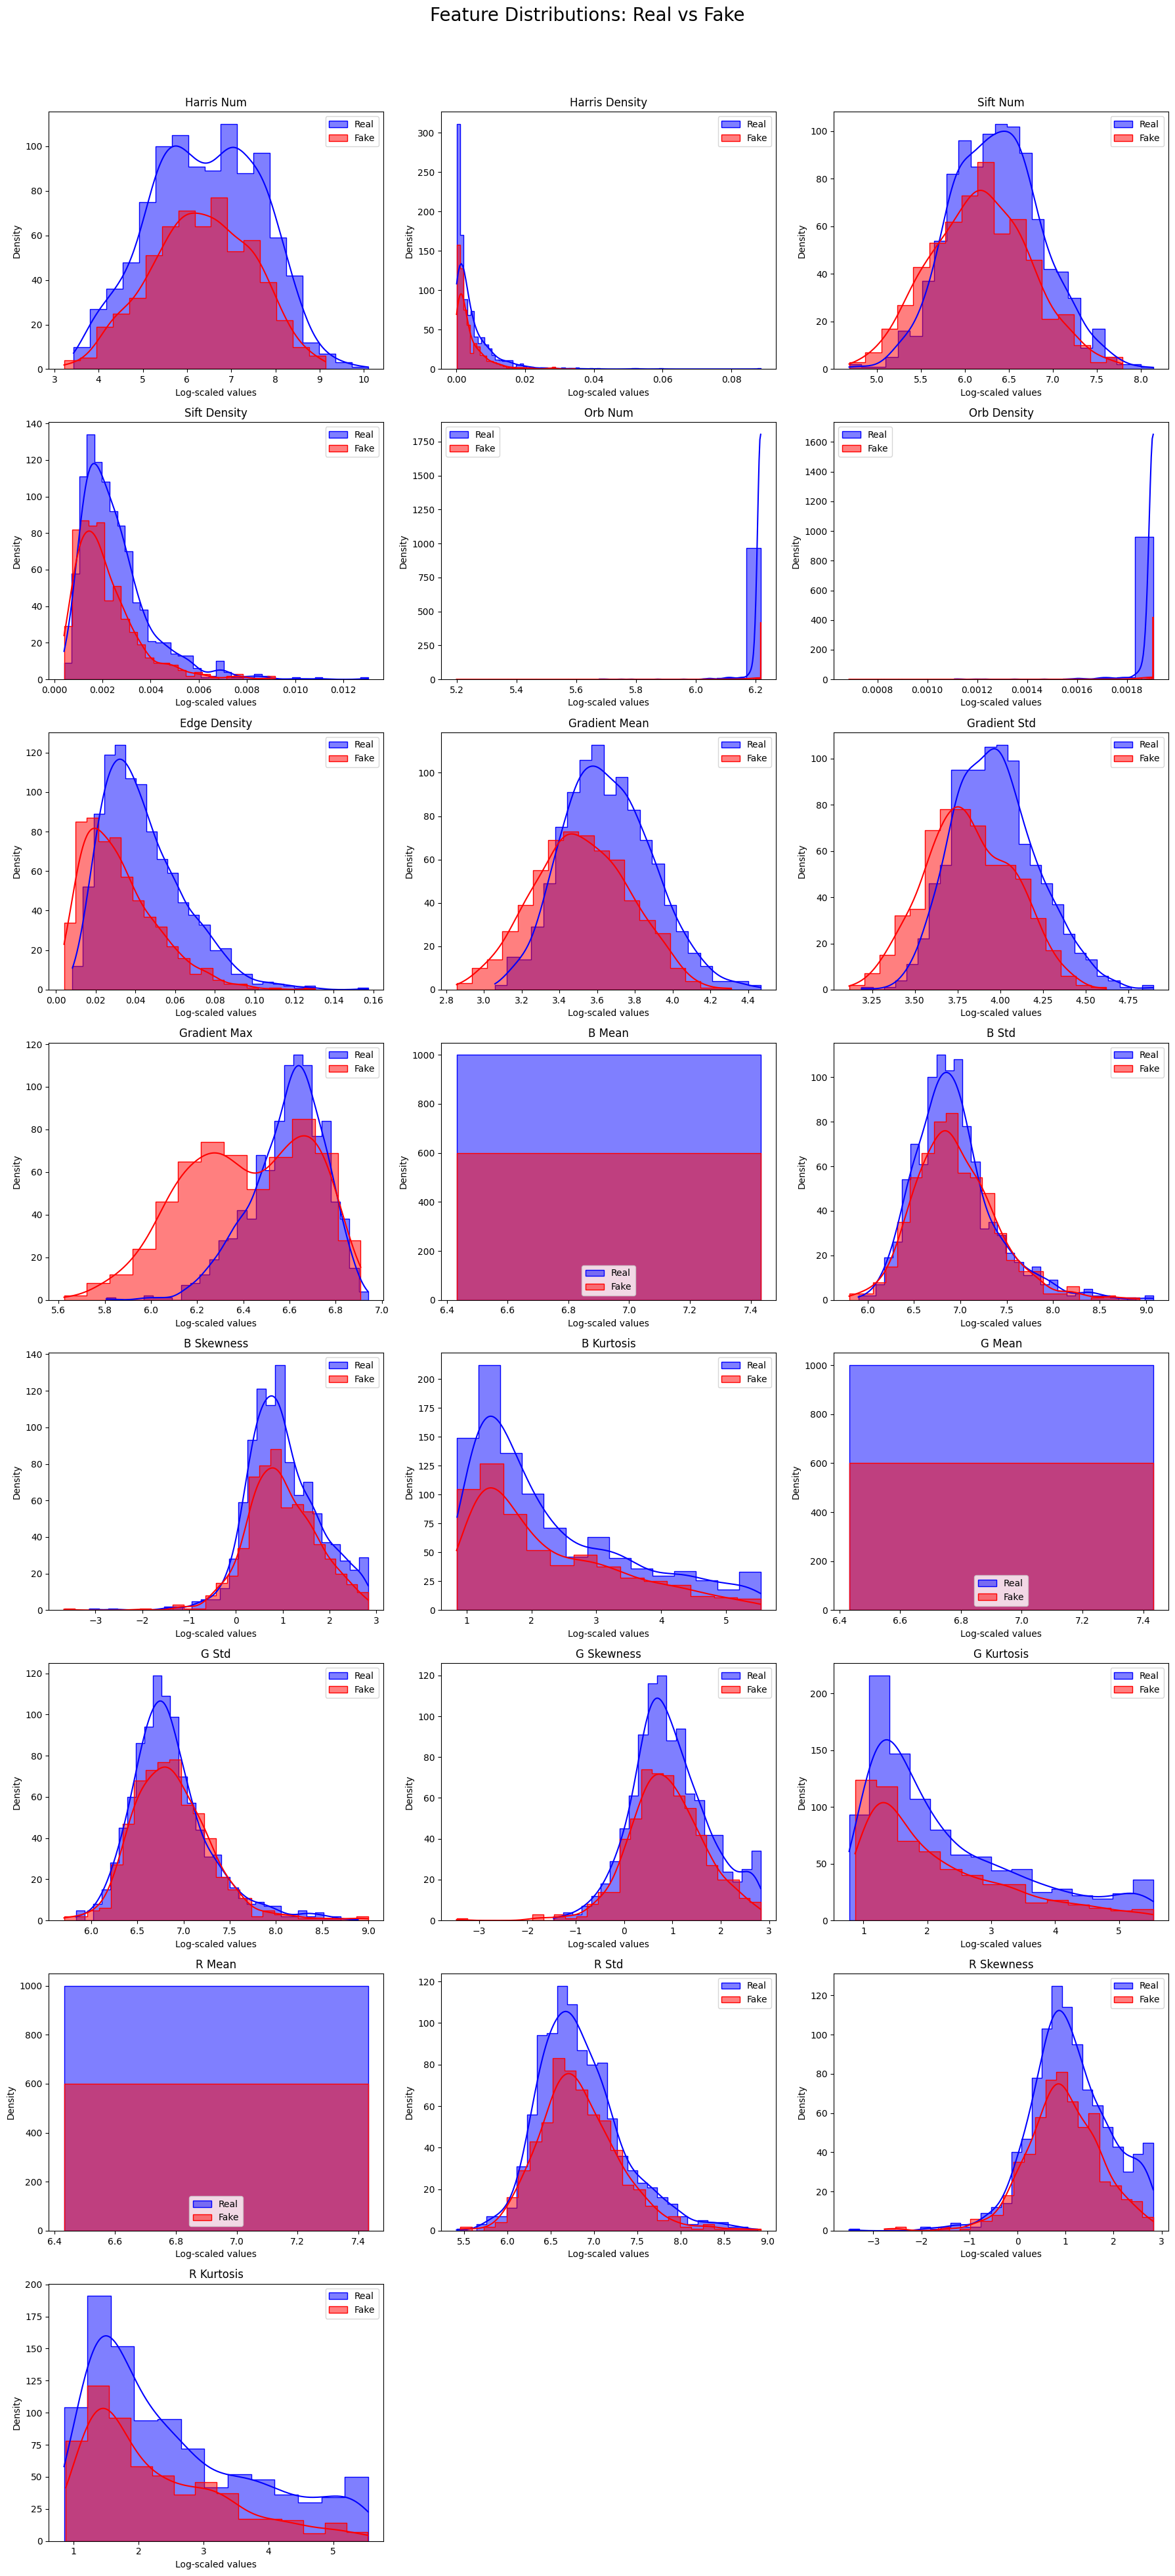

In [23]:
df = process_images(real_folders, fake_folders)

plot_histograms(df)
run_statistical_tests(df)
model = train_random_forest(df)

2. COCO Fake vs. Real

In [24]:
import os

# Define the folders
real_folders = [
    "/content/images/test_set/real_coco_valid",
#    "/content/images/test_set/real_ffhq",
#    "/content/images/test_set/real_imagenet_val"
]

fake_folders = [
    "/content/images/test_set/dalle3_cocoval",
#    "/content/images/test_set/dalle_2",
#    "/content/images/test_set/stable_diffusion_2_1_512",
#    "/content/images/test_set/stable_diffusion_2_1_768",
#    "/content/images/test_set/biggan_512",
#    "/content/images/test_set/biggan_256",
    "/content/images/test_set/GigaGAN_t2i_coco256_rep",
#    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
#    "/content/images/test_set/stylegan2_ffhq_1024x1024",
#    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")

Real Image Counts:
/content/images/test_set/real_coco_valid: 1000

Fake Image Counts:
/content/images/test_set/dalle3_cocoval: 1000
/content/images/test_set/GigaGAN_t2i_coco256_rep: 250


SIFT on 2. COCO Fake vs. Real

In [9]:
real_images = get_image_paths(real_folders)
fake_images = get_image_paths(fake_folders)

# Labels: 1 for real, 0 for fake
image_labels = [1] * len(real_images) + [0] * len(fake_images)
image_paths = real_images + fake_images

# Shuffle dataset
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)

# Initialize SIFT
sift = cv2.SIFT_create()

# Extract SIFT features
descriptors, image_features = extract_sift_features(image_paths, sift)

num_clusters = 500  # Adjust as needed
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=1024, n_init=10, max_iter=100)

# Train KMeans and free memory
kmeans.fit(descriptors)
del descriptors  # Free up memory
gc.collect()

# Convert images to BoW histograms
bow_features = create_bow_histograms(image_features, kmeans, num_clusters)

# Train-test split, keeping real and fake numbers balanced
min_samples = min(len(real_images), len(fake_images))
X = np.concatenate((bow_features[:min_samples], bow_features[-min_samples:]))
y = np.concatenate((image_labels[:min_samples], image_labels[-min_samples:]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
print("Training Random Forest...")
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Creating BoW histograms: 100%|██████████| 2250/2250 [00:20<00:00, 109.04it/s]


Training Random Forest...
Model Accuracy: 0.7300
Precision: 0.8031
Recall: 0.5514
F1 Score: 0.6538


Statistical Feature Extraction on 2. COCO Fake vs. Real


Processing /content/images/test_set/real_coco_valid...


100%|██████████| 1000/1000 [01:58<00:00,  8.42it/s]



Processing /content/images/test_set/dalle3_cocoval...


100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s]



Processing /content/images/test_set/GigaGAN_t2i_coco256_rep...


100%|██████████| 250/250 [00:30<00:00,  8.24it/s]



Saved features to image_features.csv


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



Saved histograms to feature_distributions.png

Statistical Test Results:
       Feature  T-Statistic      P-Value  Significant (p<0.05)
    harris_num     5.293939 1.338799e-07                  True
harris_density     5.293939 1.338799e-07                  True
      sift_num     4.322010 1.627480e-05                  True
  sift_density     4.322010 1.627480e-05                  True
       orb_num    -2.787715 5.378415e-03                  True
   orb_density    -2.787715 5.378415e-03                  True
  edge_density    -0.487049 6.262790e-01                 False
 gradient_mean    -5.036215 5.147775e-07                  True
  gradient_std   -11.363607 4.293524e-29                  True
  gradient_max    -9.992137 6.747695e-23                  True
        b_mean          NaN          NaN                 False
         b_std     3.373178 7.568017e-04                  True
    b_skewness     4.248431 2.256839e-05                  True
    b_kurtosis     4.150195 3.480219e-05    

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Accuracy: 0.7467

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       200
           1       0.79      0.74      0.77       250

    accuracy                           0.75       450
   macro avg       0.74      0.75      0.75       450
weighted avg       0.75      0.75      0.75       450


Feature Importances:
       Feature  Importance
         r_std    0.112465
  gradient_std    0.094293
    r_kurtosis    0.073457
         g_std    0.069894
  gradient_max    0.064275
    harris_num    0.058300
      sift_num    0.056852
harris_density    0.053903
    r_skewness    0.053506
 gradient_mean    0.050978
  sift_density    0.049444
    b_kurtosis    0.044821
    g_skewness    0.044651
    g_kurtosis    0.043642
  edge_density    0.041885
    b_skewness    0.040629
         b_std    0.040313
       orb_num    0.003419
   orb_density    0.003275
        b_mean    0.000000
        g_mean    0.000000
        r_mean 

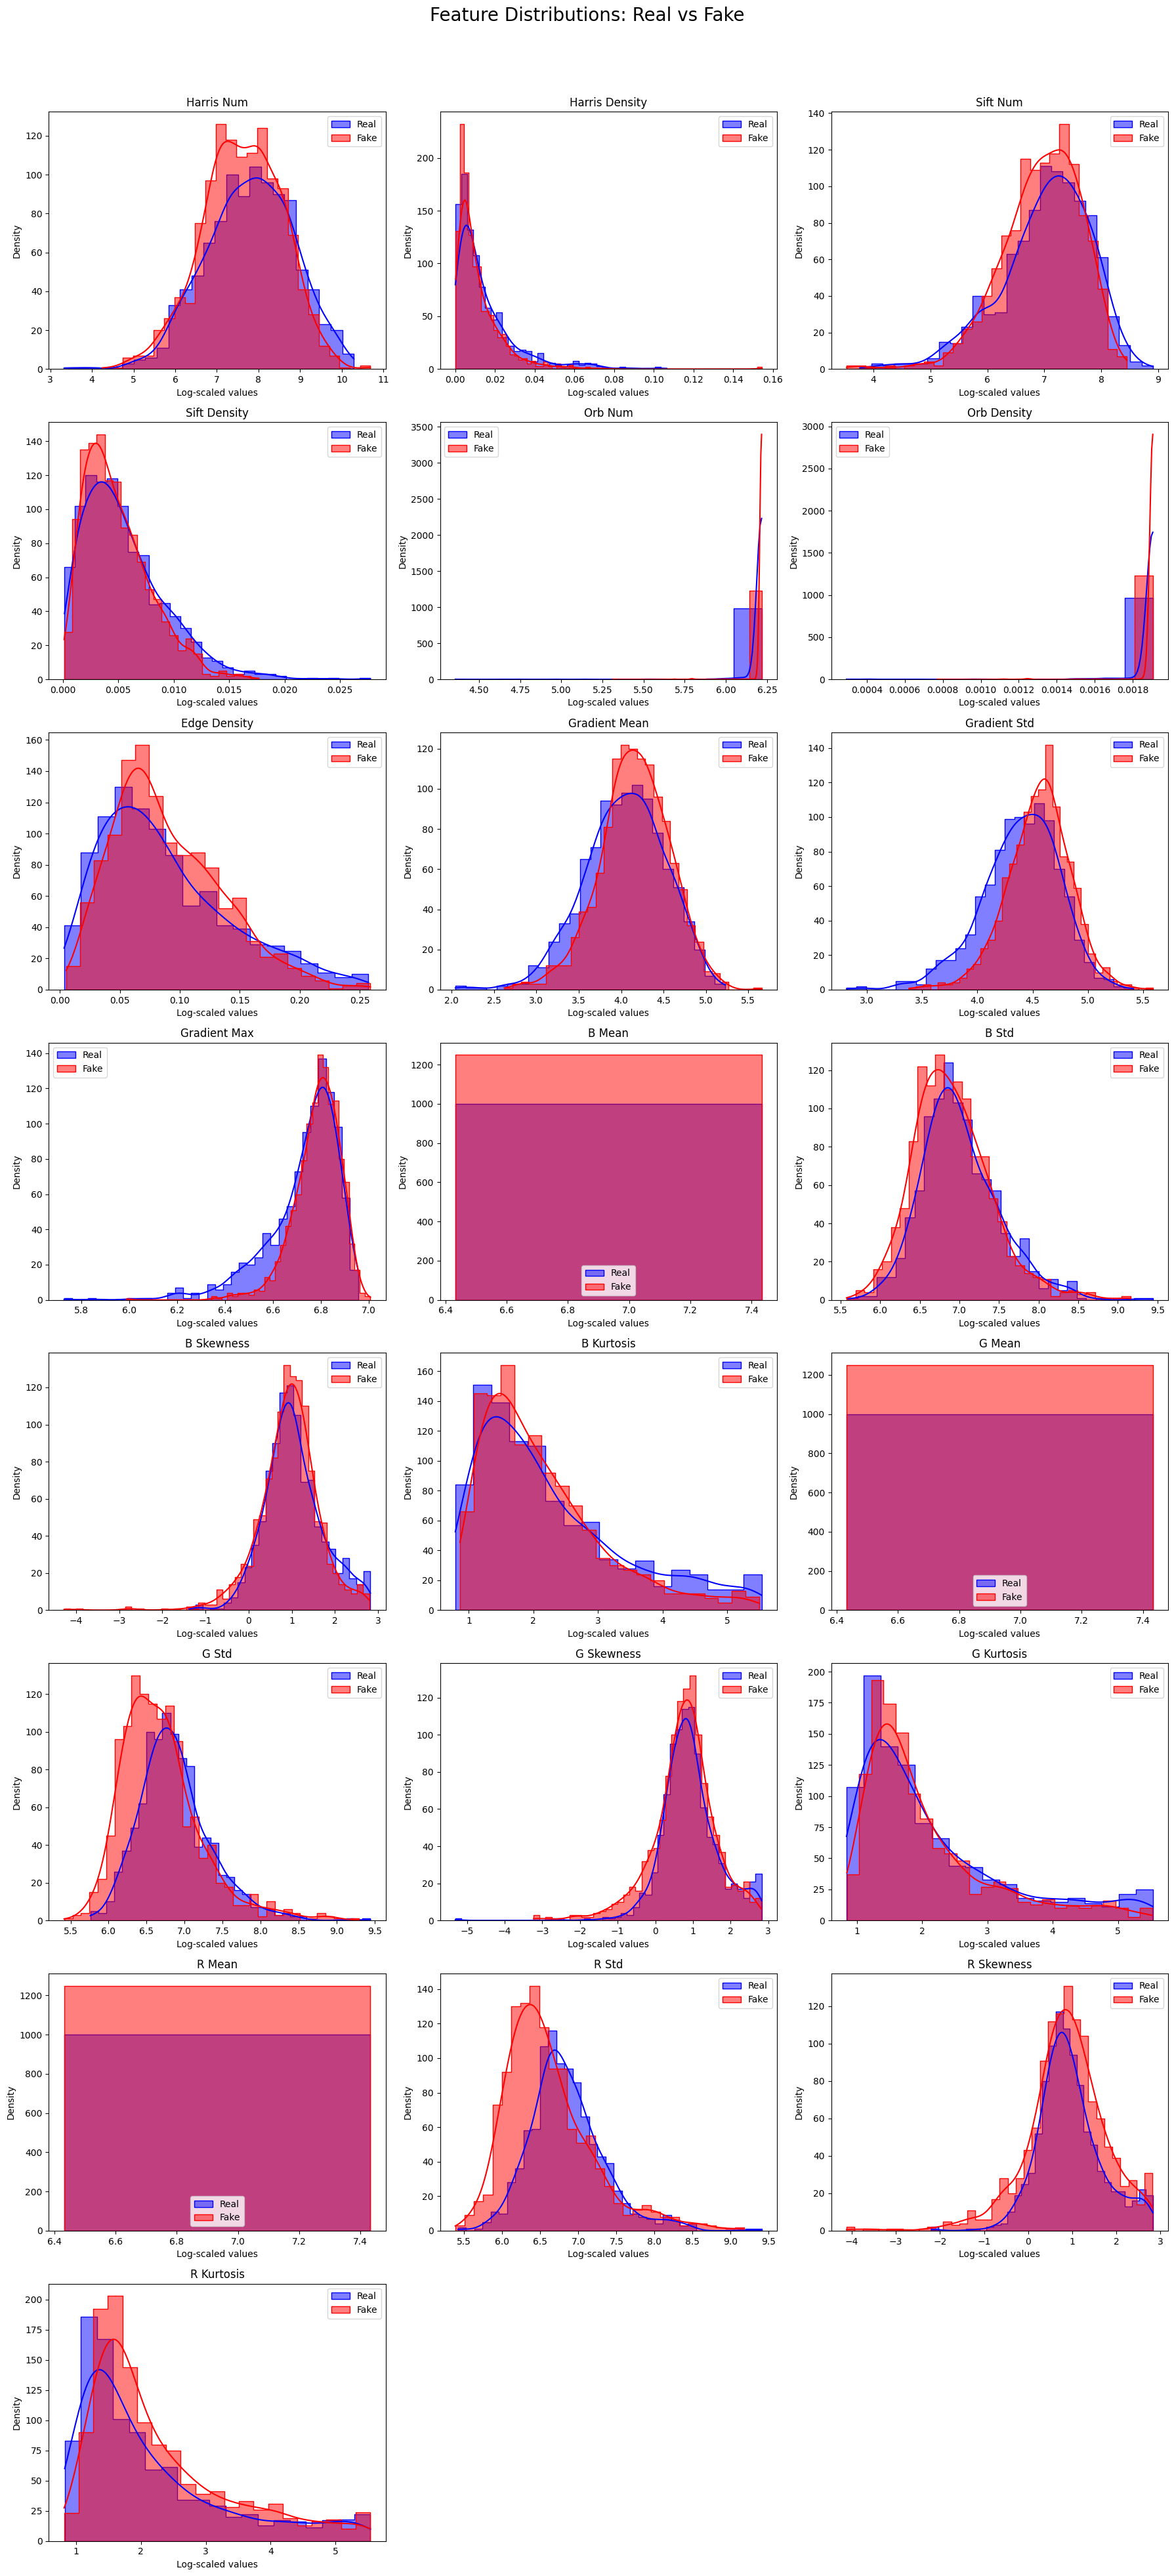

In [25]:
df = process_images(real_folders, fake_folders)

plot_histograms(df)
run_statistical_tests(df)
model = train_random_forest(df)

# In-Method Experiments

1. Real vs. DALLE2/3 (Mainly COCO kind)

In [26]:
import os

# Define the folders
real_folders = [
    "/content/images/test_set/real_coco_valid",
#    "/content/images/test_set/real_ffhq",
    "/content/images/test_set/real_imagenet_val"
]

fake_folders = [
    "/content/images/test_set/dalle3_cocoval",
    "/content/images/test_set/dalle_2",
#    "/content/images/test_set/stable_diffusion_2_1_512",
#    "/content/images/test_set/stable_diffusion_2_1_768",
#    "/content/images/test_set/biggan_512",
#    "/content/images/test_set/biggan_256",
#    "/content/images/test_set/GigaGAN_t2i_coco256_rep",
#    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
#    "/content/images/test_set/stylegan2_ffhq_1024x1024",
#    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")

Real Image Counts:
/content/images/test_set/real_coco_valid: 1000
/content/images/test_set/real_imagenet_val: 1000

Fake Image Counts:
/content/images/test_set/dalle3_cocoval: 1000
/content/images/test_set/dalle_2: 1000


SIFT on 1. Real vs. DALLE2/3 (Mainly COCO kind)

In [11]:
real_images = get_image_paths(real_folders)
fake_images = get_image_paths(fake_folders)

# Labels: 1 for real, 0 for fake
image_labels = [1] * len(real_images) + [0] * len(fake_images)
image_paths = real_images + fake_images

# Shuffle dataset
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)

# Initialize SIFT
sift = cv2.SIFT_create()

# Extract SIFT features
descriptors, image_features = extract_sift_features(image_paths, sift)

num_clusters = 500  # Adjust as needed
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=1024, n_init=10, max_iter=100)

# Train KMeans and free memory
kmeans.fit(descriptors)
del descriptors  # Free up memory
gc.collect()

# Convert images to BoW histograms
bow_features = create_bow_histograms(image_features, kmeans, num_clusters)

# Train-test split, keeping real and fake numbers balanced
min_samples = min(len(real_images), len(fake_images))
X = np.concatenate((bow_features[:min_samples], bow_features[-min_samples:]))
y = np.concatenate((image_labels[:min_samples], image_labels[-min_samples:]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
print("Training Random Forest...")
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Creating BoW histograms: 100%|██████████| 3000/3000 [00:17<00:00, 169.19it/s]


Training Random Forest...
Model Accuracy: 0.7200
Precision: 0.7143
Recall: 0.3237
F1 Score: 0.4455


Statistical Feature Extraction on 1. Real vs. DALLE2/3 (Mainly COCO kind)


Processing /content/images/test_set/real_coco_valid...


100%|██████████| 1000/1000 [01:53<00:00,  8.81it/s]



Processing /content/images/test_set/real_imagenet_val...


100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s]



Processing /content/images/test_set/dalle3_cocoval...


100%|██████████| 1000/1000 [02:38<00:00,  6.32it/s]



Processing /content/images/test_set/dalle_2...


100%|██████████| 1000/1000 [02:38<00:00,  6.32it/s]



Saved features to image_features.csv


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



Saved histograms to feature_distributions.png

Statistical Test Results:
       Feature  T-Statistic      P-Value  Significant (p<0.05)
    harris_num    11.857522 8.755688e-32                  True
harris_density    11.857522 8.755688e-32                  True
      sift_num    11.059419 5.569769e-28                  True
  sift_density    11.059419 5.569769e-28                  True
       orb_num     0.331120 7.405712e-01                 False
   orb_density     0.331120 7.405712e-01                 False
  edge_density     3.678626 2.377445e-04                  True
 gradient_mean     0.665701 5.056410e-01                 False
  gradient_std    -7.372443 2.025432e-13                  True
  gradient_max    -5.669584 1.538340e-08                  True
        b_mean          NaN          NaN                 False
         b_std     3.483083 5.011299e-04                  True
    b_skewness     2.031650 4.225885e-02                  True
    b_kurtosis     4.353198 1.381541e-05    

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Accuracy: 0.7225

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       400
           1       0.72      0.72      0.72       400

    accuracy                           0.72       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.72      0.72      0.72       800


Feature Importances:
       Feature  Importance
         r_std    0.090306
harris_density    0.081556
    r_kurtosis    0.077871
    harris_num    0.077164
  gradient_std    0.072628
         g_std    0.070497
      sift_num    0.061367
  sift_density    0.059386
    b_kurtosis    0.052992
  gradient_max    0.052077
    g_skewness    0.048352
 gradient_mean    0.045555
  edge_density    0.044002
    g_kurtosis    0.041636
    r_skewness    0.041476
    b_skewness    0.039936
         b_std    0.031161
       orb_num    0.006188
   orb_density    0.005848
        g_mean    0.000000
        r_mean    0.000000
        b_mean 

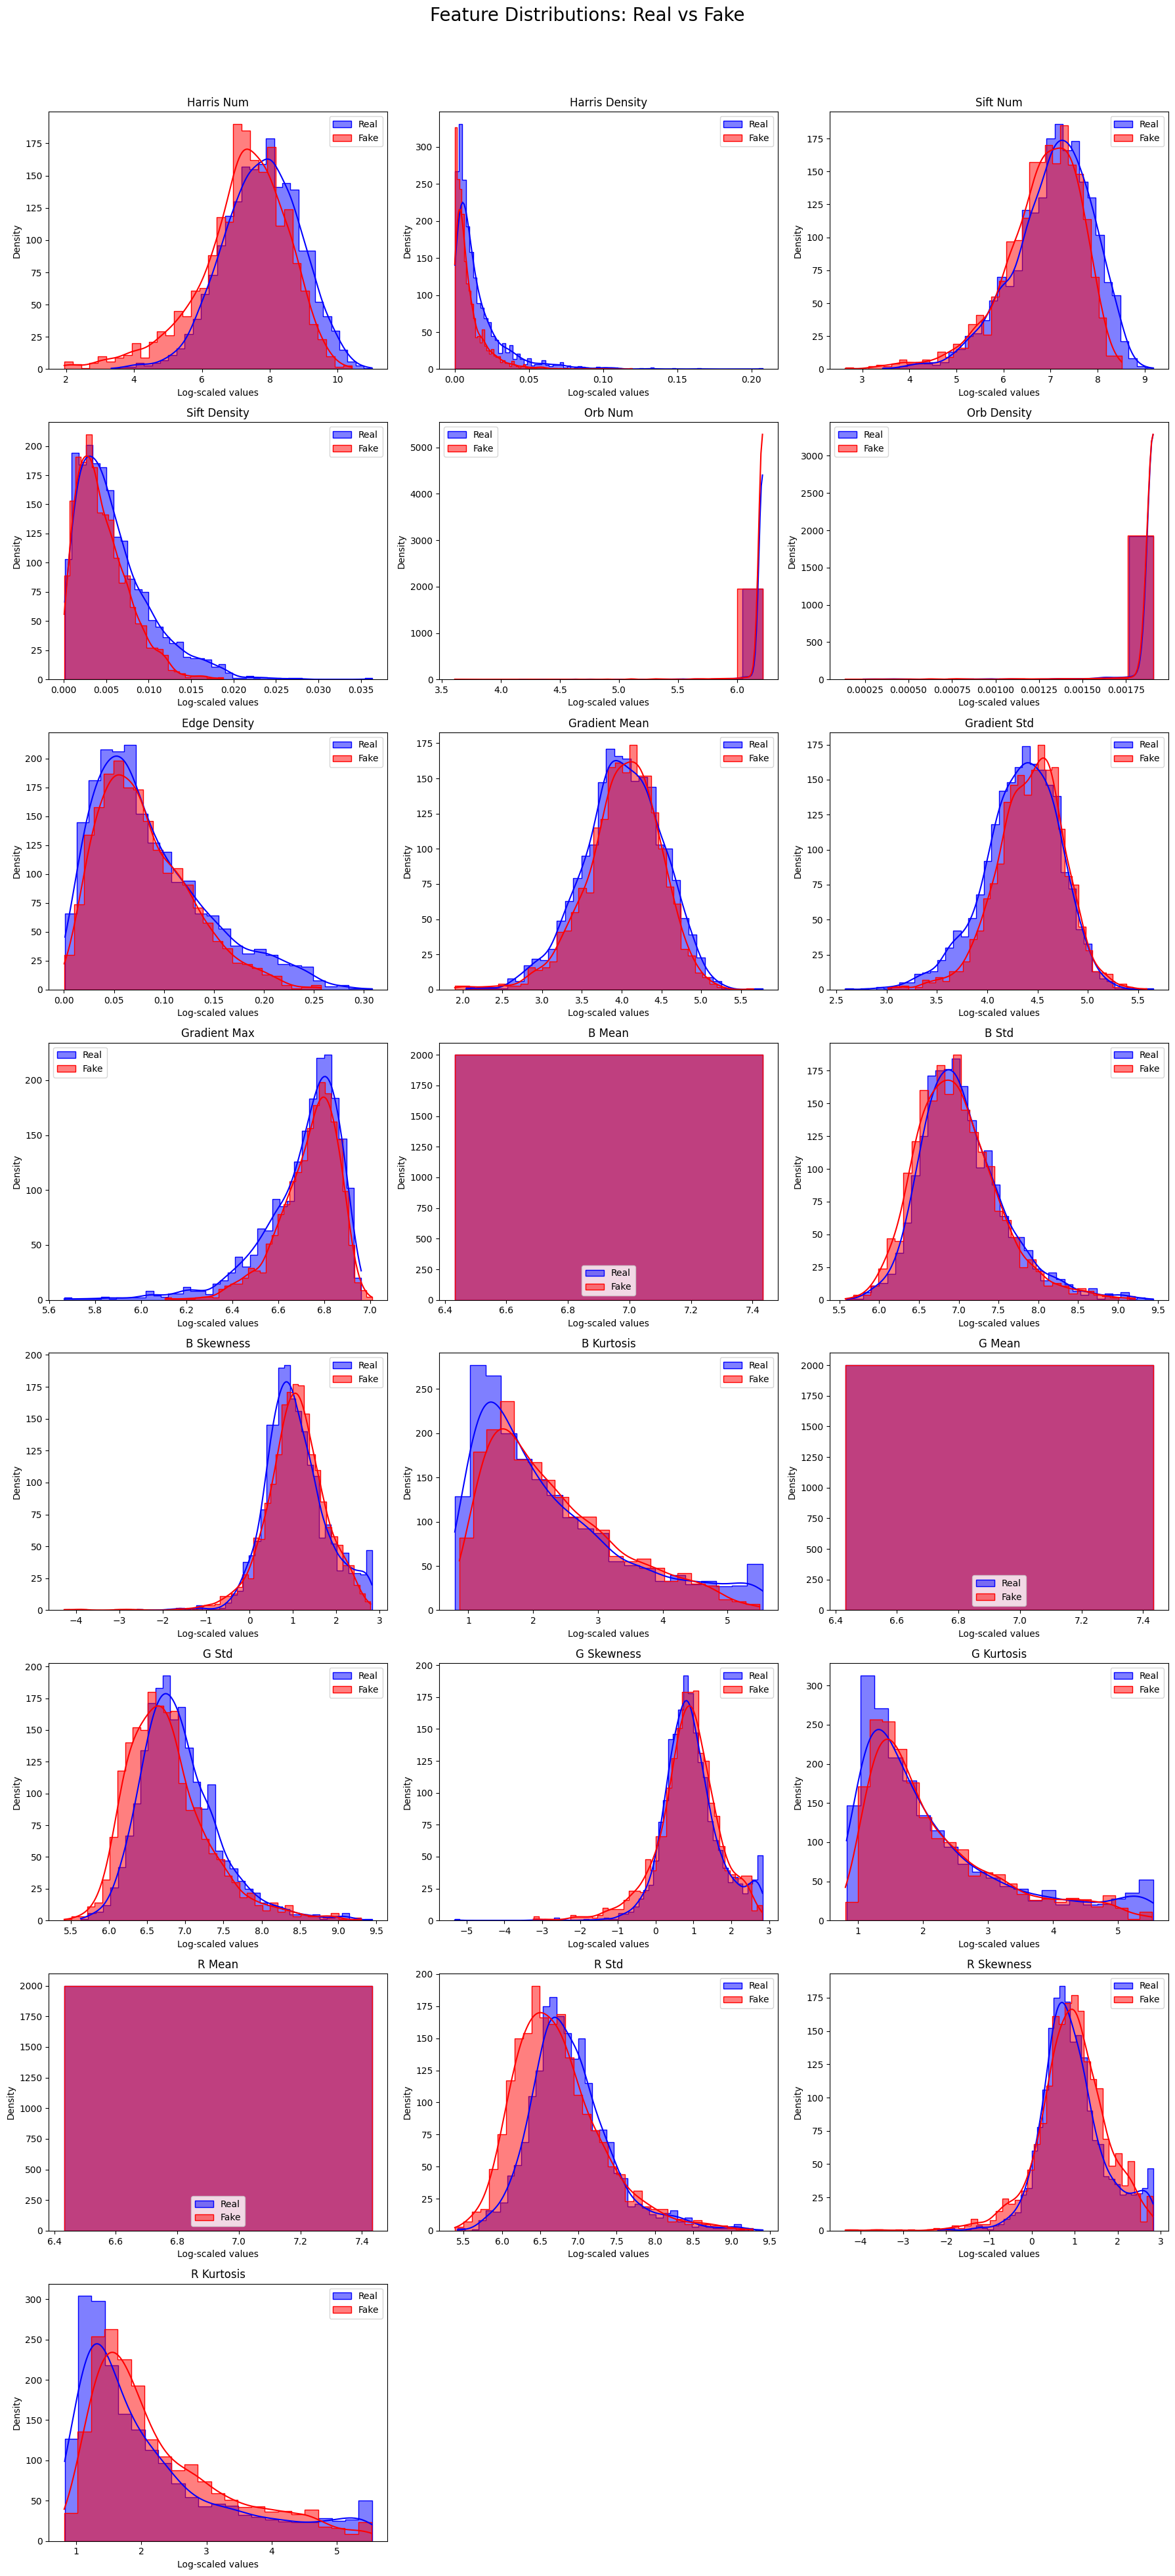

In [27]:
df = process_images(real_folders, fake_folders)

plot_histograms(df)
run_statistical_tests(df)
model = train_random_forest(df)

2. Real vs. SDXL/SD2 (Mainly COCO kind)

In [28]:
import os

# Define the folders
real_folders = [
    "/content/images/test_set/real_coco_valid",
#    "/content/images/test_set/real_ffhq",
    "/content/images/test_set/real_imagenet_val"
]

fake_folders = [
#    "/content/images/test_set/dalle3_cocoval",
#    "/content/images/test_set/dalle_2",
    "/content/images/test_set/stable_diffusion_2_1_512",
    "/content/images/test_set/stable_diffusion_2_1_768",
     "/content/images/test_set/sdxl_cocoval"
#    "/content/images/test_set/biggan_512",
#    "/content/images/test_set/biggan_256",
#    "/content/images/test_set/GigaGAN_t2i_coco256_rep",
#    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
#    "/content/images/test_set/stylegan2_ffhq_1024x1024",
#    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")

Real Image Counts:
/content/images/test_set/real_coco_valid: 1000
/content/images/test_set/real_imagenet_val: 1000

Fake Image Counts:
/content/images/test_set/stable_diffusion_2_1_512: 400
/content/images/test_set/stable_diffusion_2_1_768: 300
/content/images/test_set/sdxl_cocoval: 1000


SIFT on 2. Real vs. SDXL/SD2 (Mainly COCO kind)

In [13]:
real_images = get_image_paths(real_folders)
fake_images = get_image_paths(fake_folders)

# Labels: 1 for real, 0 for fake
image_labels = [1] * len(real_images) + [0] * len(fake_images)
image_paths = real_images + fake_images

# Shuffle dataset
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)

# Initialize SIFT
sift = cv2.SIFT_create()

# Extract SIFT features
descriptors, image_features = extract_sift_features(image_paths, sift)

num_clusters = 500  # Adjust as needed
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=1024, n_init=10, max_iter=100)

# Train KMeans and free memory
kmeans.fit(descriptors)
del descriptors  # Free up memory
gc.collect()

# Convert images to BoW histograms
bow_features = create_bow_histograms(image_features, kmeans, num_clusters)

# Train-test split, keeping real and fake numbers balanced
min_samples = min(len(real_images), len(fake_images))
X = np.concatenate((bow_features[:min_samples], bow_features[-min_samples:]))
y = np.concatenate((image_labels[:min_samples], image_labels[-min_samples:]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
print("Training Random Forest...")
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Creating BoW histograms: 100%|██████████| 2700/2700 [00:16<00:00, 164.29it/s]


Training Random Forest...
Model Accuracy: 0.6875
Precision: 0.7424
Recall: 0.3121
F1 Score: 0.4395


Statistical Feature Extraction on 2. Real vs. SDXL/SD2 (Mainly COCO kind)


Processing /content/images/test_set/real_coco_valid...


100%|██████████| 1000/1000 [01:56<00:00,  8.58it/s]



Processing /content/images/test_set/real_imagenet_val...


100%|██████████| 1000/1000 [01:56<00:00,  8.60it/s]



Processing /content/images/test_set/stable_diffusion_2_1_512...


100%|██████████| 400/400 [00:49<00:00,  8.00it/s]



Processing /content/images/test_set/stable_diffusion_2_1_768...


100%|██████████| 300/300 [00:42<00:00,  7.11it/s]



Processing /content/images/test_set/sdxl_cocoval...


100%|██████████| 1000/1000 [02:38<00:00,  6.31it/s]



Saved features to image_features.csv


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



Saved histograms to feature_distributions.png

Statistical Test Results:
       Feature  T-Statistic      P-Value  Significant (p<0.05)
    harris_num     9.333327 1.824399e-20                  True
harris_density     9.333327 1.824399e-20                  True
      sift_num    12.428661 9.386400e-35                  True
  sift_density    12.428661 9.386400e-35                  True
       orb_num    -3.675119 2.414313e-04                  True
   orb_density    -3.675119 2.414313e-04                  True
  edge_density     7.773112 9.988330e-15                  True
 gradient_mean     3.430775 6.084749e-04                  True
  gradient_std    -7.145596 1.079004e-12                  True
  gradient_max     6.389268 1.878014e-10                  True
        b_mean          NaN          NaN                 False
         b_std     8.318025 1.290238e-16                  True
    b_skewness     6.855307 8.340919e-12                  True
    b_kurtosis     6.645491 3.505522e-11    

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Accuracy: 0.7689

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       400
           1       0.75      0.75      0.75       340

    accuracy                           0.77       740
   macro avg       0.77      0.77      0.77       740
weighted avg       0.77      0.77      0.77       740


Feature Importances:
       Feature  Importance
  gradient_std    0.132884
  gradient_max    0.095496
      sift_num    0.084290
  sift_density    0.081878
  edge_density    0.069272
 gradient_mean    0.059705
         b_std    0.051827
harris_density    0.048058
    harris_num    0.047461
    g_skewness    0.043951
         r_std    0.043823
         g_std    0.039274
    g_kurtosis    0.038658
    r_kurtosis    0.037385
    b_skewness    0.037105
    r_skewness    0.036945
    b_kurtosis    0.036284
       orb_num    0.008107
   orb_density    0.007594
        b_mean    0.000000
        g_mean    0.000000
        r_mean 

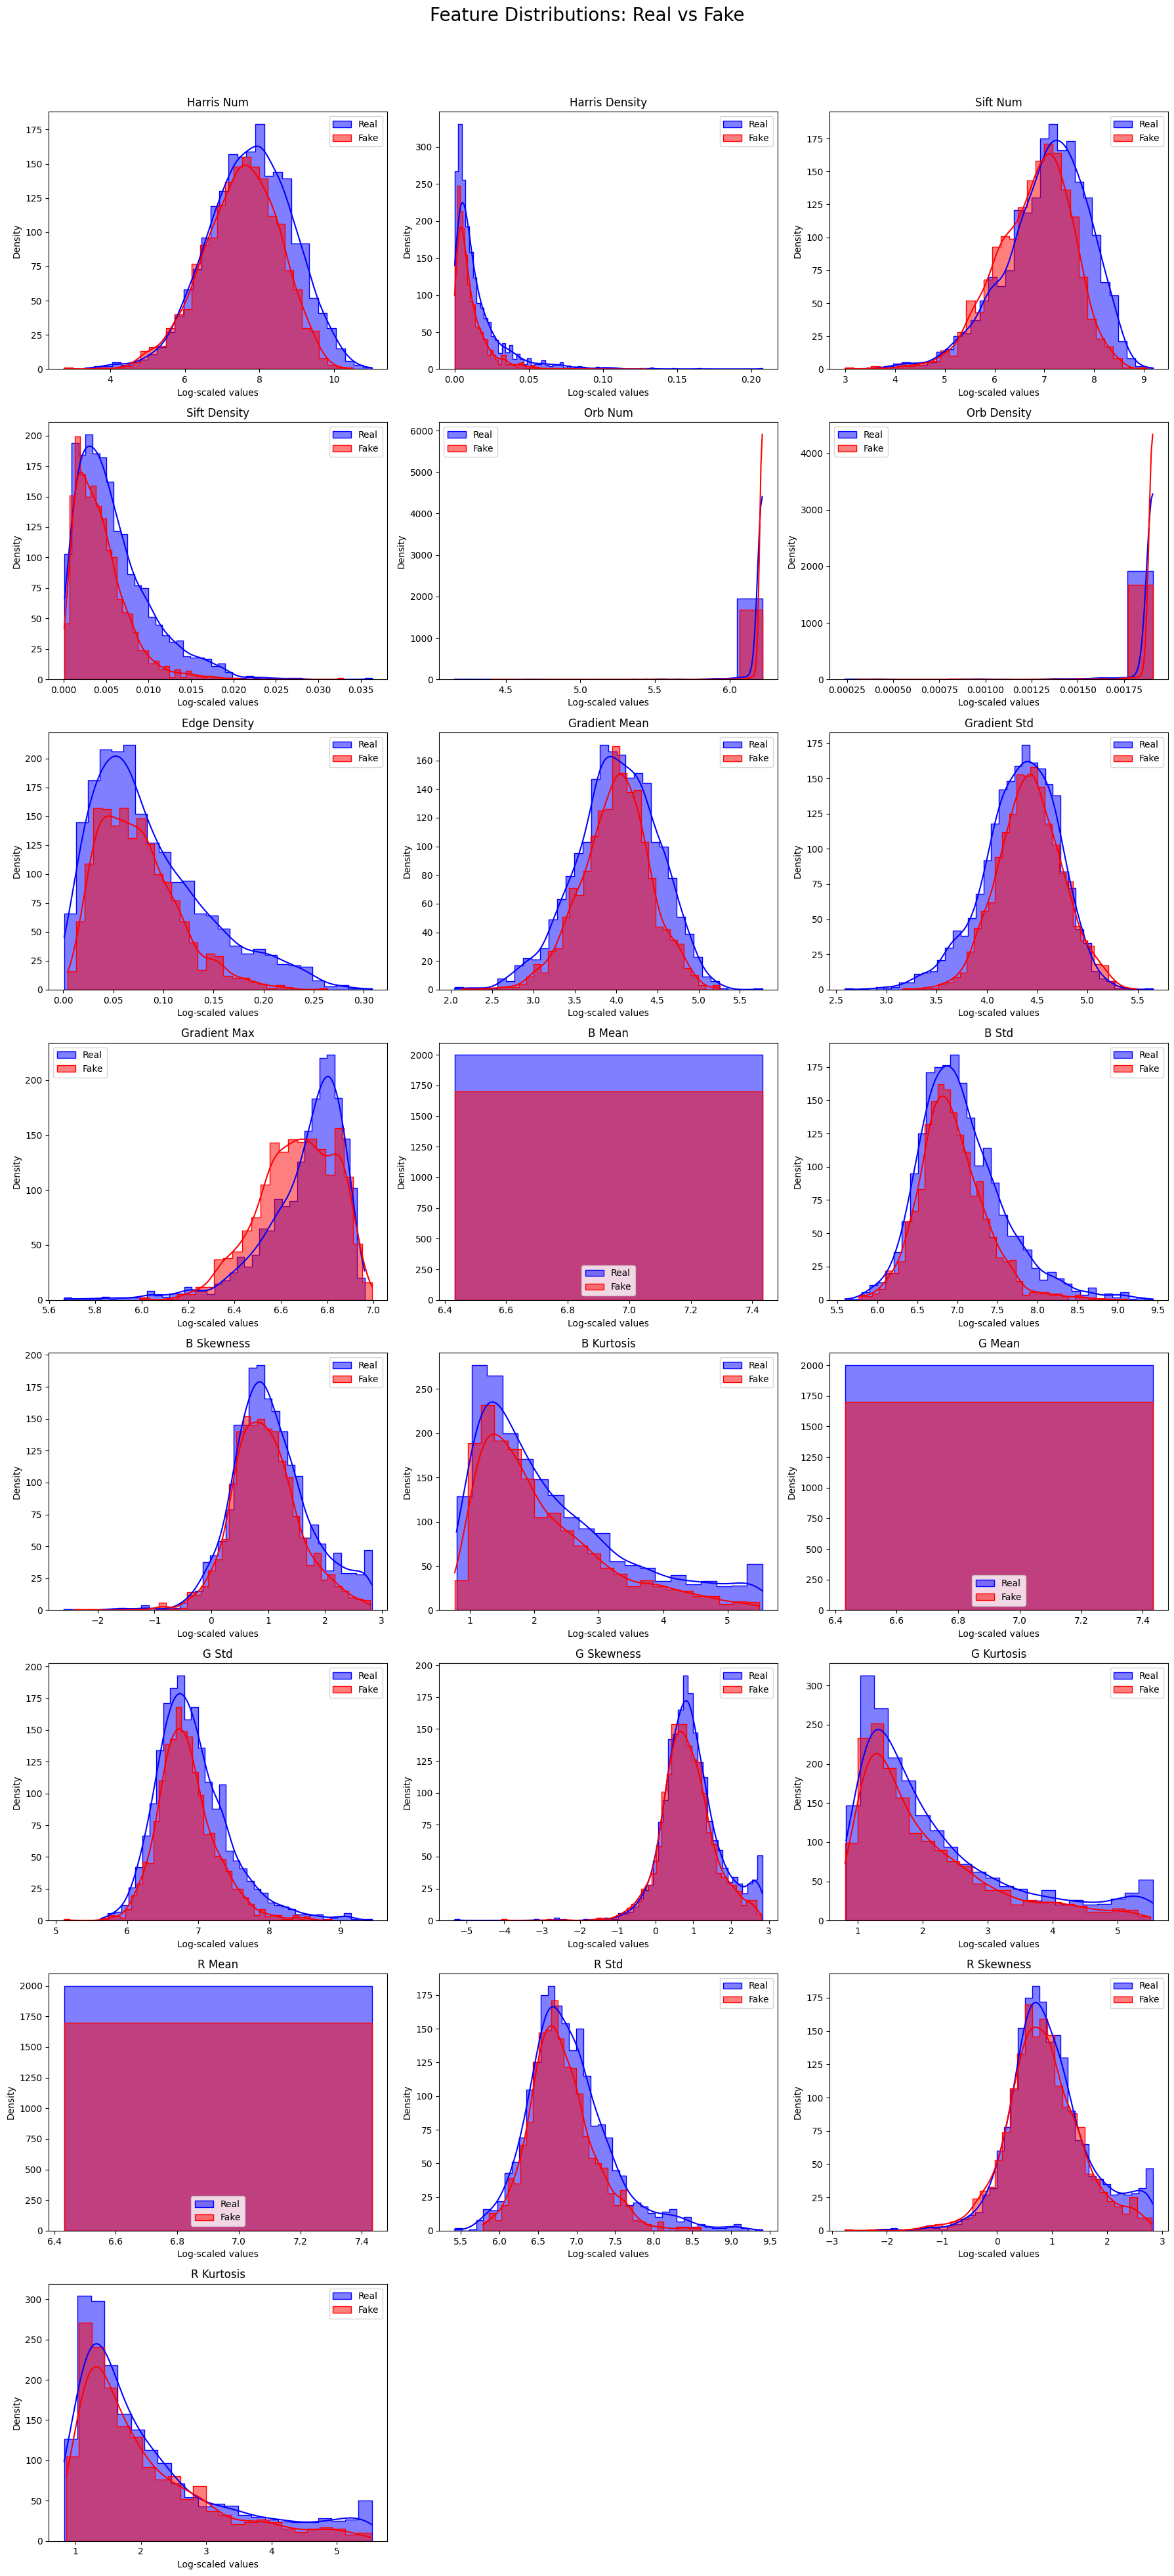

In [29]:
df = process_images(real_folders, fake_folders)

plot_histograms(df)
run_statistical_tests(df)
model = train_random_forest(df)

# Real vs. Fake Comprehensive Experiments

Real COCO + ImageNet vs. DALLE 3 + Stable Diffusion + BigGAN

In [30]:
import os

# Define the folders
real_folders = [
    "/content/images/test_set/real_coco_valid",
#    "/content/images/test_set/real_ffhq",
    "/content/images/test_set/real_imagenet_val"
]

fake_folders = [
    "/content/images/test_set/dalle3_cocoval",
#    "/content/images/test_set/dalle_2",
    "/content/images/test_set/stable_diffusion_2_1_512",
#    "/content/images/test_set/stable_diffusion_2_1_768",
#     "/content/images/test_set/sdxl_cocoval",
     "/content/images/test_set/biggan_512",
#    "/content/images/test_set/biggan_256",
#    "/content/images/test_set/GigaGAN_t2i_coco256_rep",
#    "/content/images/test_set/latent-diffusion_noise2image_FFHQ",
#    "/content/images/test_set/stylegan2_ffhq_1024x1024",
#    "/content/images/test_set/stylegan2_ffhq_256x256"
]


# Count images
real_counts = count_images(real_folders)
fake_counts = count_images(fake_folders)

# Print results
print("Real Image Counts:")
for folder, count in real_counts.items():
    print(f"{folder}: {count}")

print("\nFake Image Counts:")
for folder, count in fake_counts.items():
    print(f"{folder}: {count}")

Real Image Counts:
/content/images/test_set/real_coco_valid: 1000
/content/images/test_set/real_imagenet_val: 1000

Fake Image Counts:
/content/images/test_set/dalle3_cocoval: 1000
/content/images/test_set/stable_diffusion_2_1_512: 400
/content/images/test_set/biggan_512: 500


SIFT on Real COCO + ImageNet vs. DALLE 3 + Stable Diffusion + BigGAN

In [15]:
real_images = get_image_paths(real_folders)
fake_images = get_image_paths(fake_folders)

# Labels: 1 for real, 0 for fake
image_labels = [1] * len(real_images) + [0] * len(fake_images)
image_paths = real_images + fake_images

# Shuffle dataset
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)

# Initialize SIFT
sift = cv2.SIFT_create()

# Extract SIFT features
descriptors, image_features = extract_sift_features(image_paths, sift)

num_clusters = 500  # Adjust as needed
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=1024, n_init=10, max_iter=100)

# Train KMeans and free memory
kmeans.fit(descriptors)
del descriptors  # Free up memory
gc.collect()

# Convert images to BoW histograms
bow_features = create_bow_histograms(image_features, kmeans, num_clusters)

# Train-test split, keeping real and fake numbers balanced
min_samples = min(len(real_images), len(fake_images))
X = np.concatenate((bow_features[:min_samples], bow_features[-min_samples:]))
y = np.concatenate((image_labels[:min_samples], image_labels[-min_samples:]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
print("Training Random Forest...")
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Creating BoW histograms: 100%|██████████| 2900/2900 [00:24<00:00, 120.46it/s]


Training Random Forest...
Model Accuracy: 0.6950
Precision: 0.6774
Recall: 0.2917
F1 Score: 0.4078


Statistical Feature Extraction on Real COCO + ImageNet vs. DALLE 3 + Stable Diffusion + BigGAN


Processing /content/images/test_set/real_coco_valid...


100%|██████████| 1000/1000 [01:54<00:00,  8.71it/s]



Processing /content/images/test_set/real_imagenet_val...


100%|██████████| 1000/1000 [01:52<00:00,  8.89it/s]



Processing /content/images/test_set/dalle3_cocoval...


100%|██████████| 1000/1000 [02:39<00:00,  6.27it/s]



Processing /content/images/test_set/stable_diffusion_2_1_512...


100%|██████████| 400/400 [00:47<00:00,  8.45it/s]



Processing /content/images/test_set/biggan_512...


100%|██████████| 500/500 [01:05<00:00,  7.68it/s]



Saved features to image_features.csv


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



Saved histograms to feature_distributions.png

Statistical Test Results:
       Feature  T-Statistic      P-Value  Significant (p<0.05)
    harris_num     2.953969 3.155990e-03                  True
harris_density     2.953969 3.155990e-03                  True
      sift_num     2.388052 1.698542e-02                  True
  sift_density     2.388052 1.698542e-02                  True
       orb_num    -1.794951 7.273937e-02                 False
   orb_density    -1.794951 7.273937e-02                 False
  edge_density    -2.451561 1.426741e-02                  True
 gradient_mean    -7.391629 1.767038e-13                  True
  gradient_std   -13.876506 9.337032e-43                  True
  gradient_max   -10.554112 1.082234e-25                  True
        b_mean          NaN          NaN                 False
         b_std     4.431765 9.603788e-06                  True
    b_skewness     4.076415 4.665827e-05                  True
    b_kurtosis     3.843251 1.234005e-04    

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Accuracy: 0.7128

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       400
           1       0.73      0.66      0.69       380

    accuracy                           0.71       780
   macro avg       0.71      0.71      0.71       780
weighted avg       0.71      0.71      0.71       780


Feature Importances:
       Feature  Importance
  gradient_std    0.101415
         r_std    0.092505
  sift_density    0.067341
      sift_num    0.066455
         g_std    0.066371
    r_kurtosis    0.058630
 gradient_mean    0.058441
  gradient_max    0.057223
harris_density    0.055986
    harris_num    0.053848
    r_skewness    0.047498
    g_skewness    0.046588
         b_std    0.045074
    b_kurtosis    0.044740
  edge_density    0.043837
    g_kurtosis    0.042920
    b_skewness    0.041092
       orb_num    0.005052
   orb_density    0.004983
        b_mean    0.000000
        g_mean    0.000000
        r_mean 

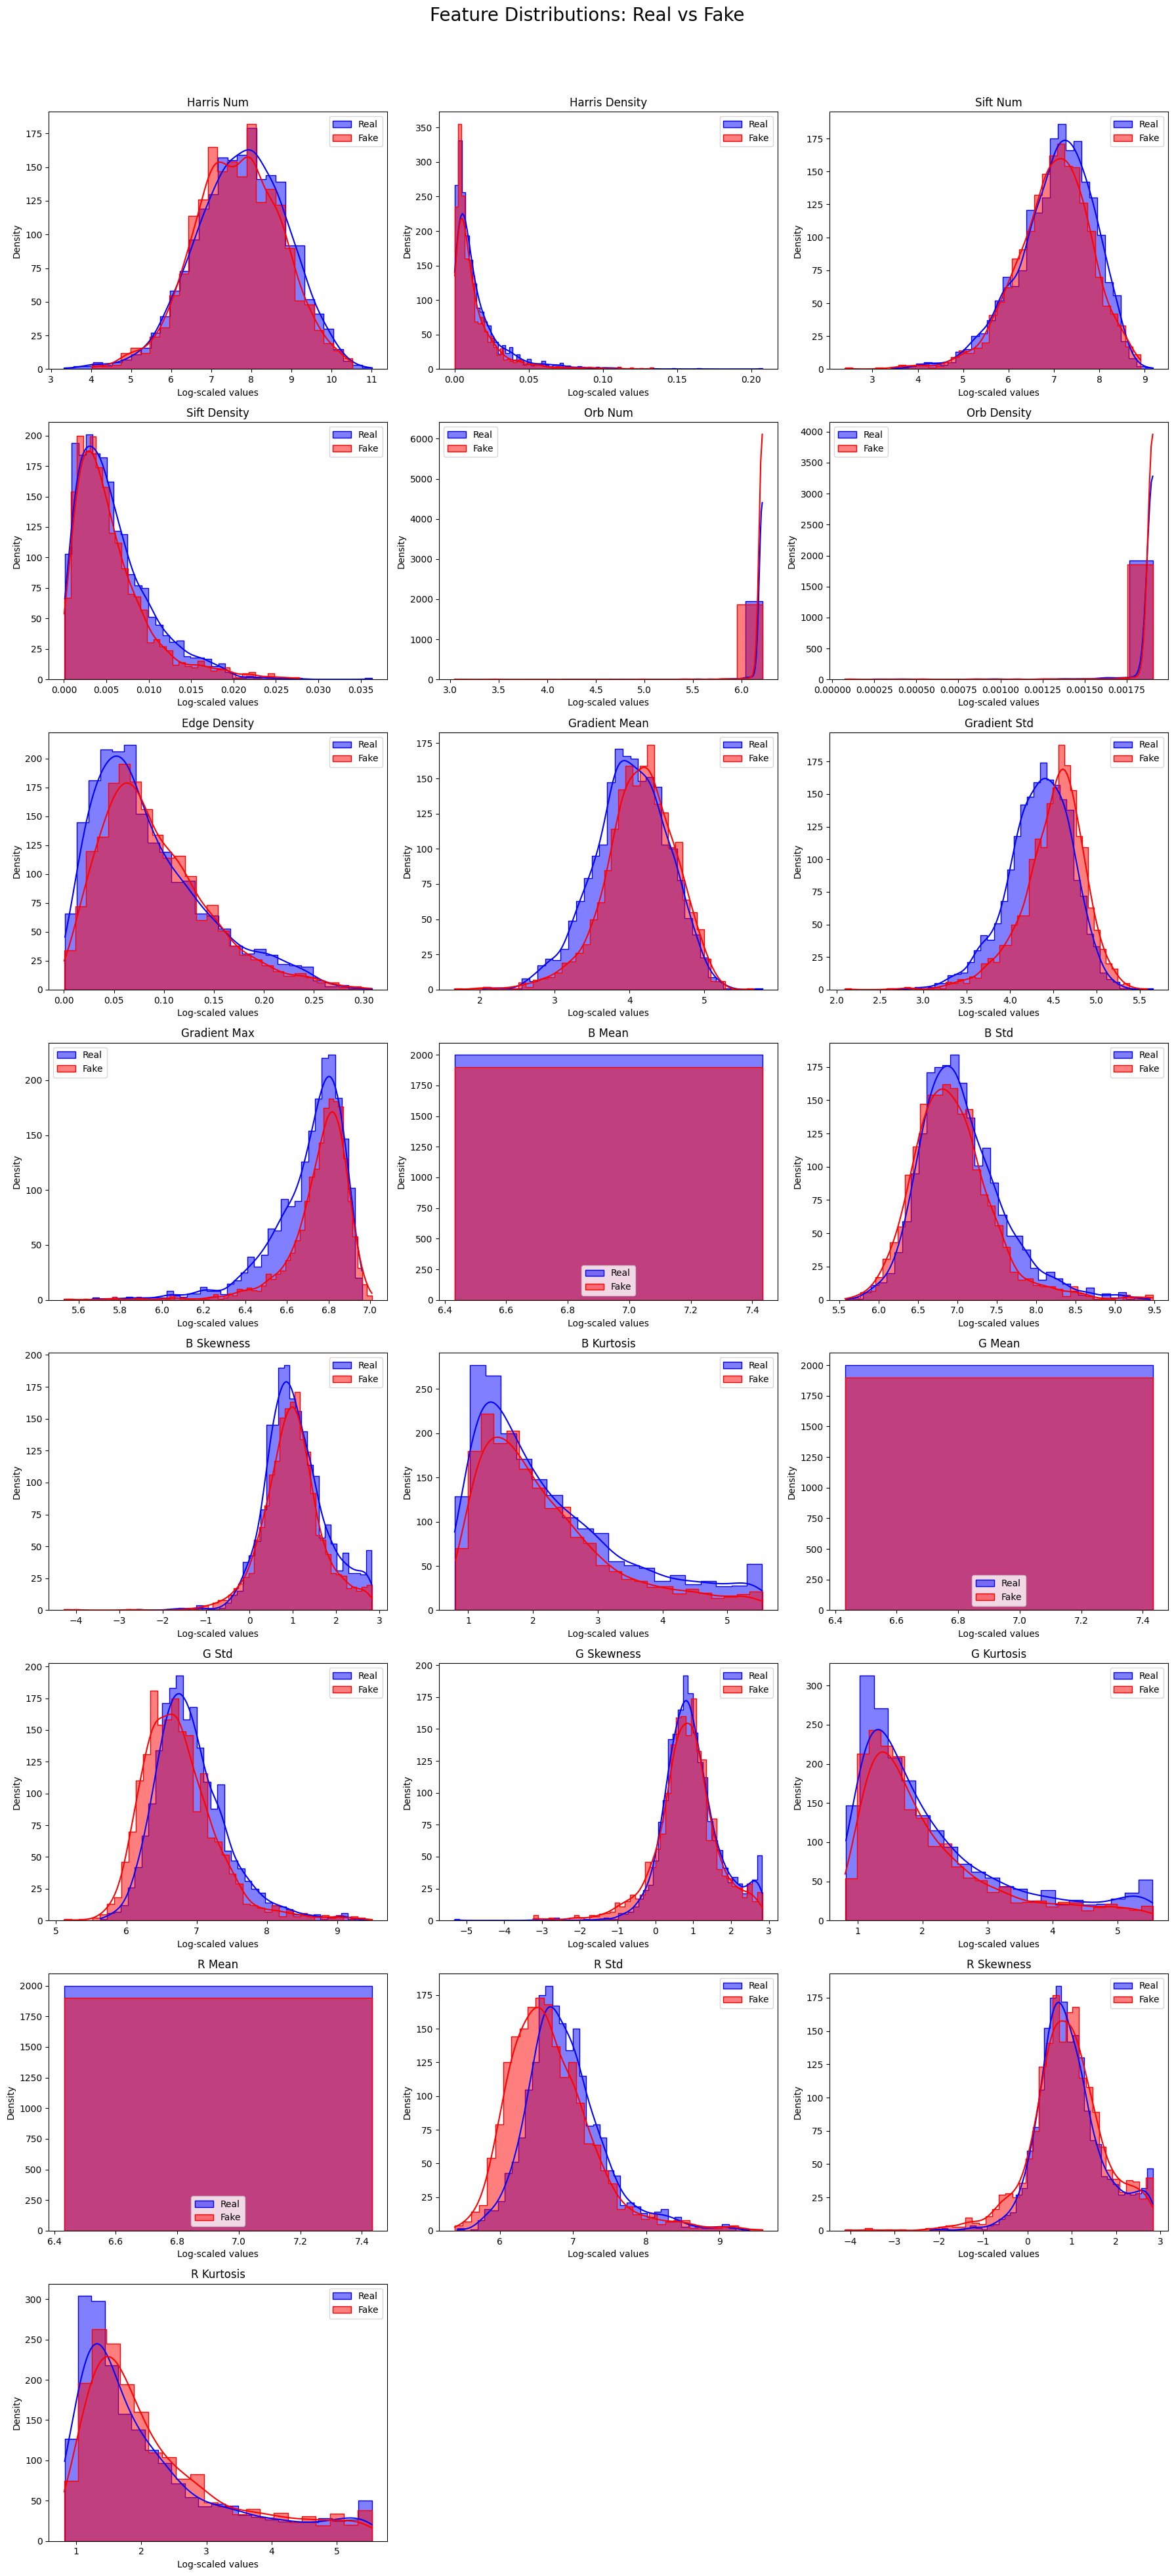

In [31]:
df = process_images(real_folders, fake_folders)

plot_histograms(df)
run_statistical_tests(df)
model = train_random_forest(df)